In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_min_both_pct_0.5/clones/variants_prefilterMerge_impute/knn/kparam_30/cells_meta.tsv" 
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_min_both_pct_0.5/clonal_shifts/variants_prefilterMerge_impute/clones/results/inputOnly/knn/kparam_30" 
d = "0"
#N_DONORS = 5 

condition = "inputOnly" #inputOnly

#config
input_cond = "Input"
clone_col = "name"
atac_col = "cluster_labels"
n_cpus = 8

# params
min_clone_size = 2
p_thresh = 0.1 
n_shuffle=1000


#conds_sep = False


In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm
from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs
from icecream import ic

%load_ext autoreload
%autoreload 2

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
# for d in np.arange(N_DONORS):
#     donor_out[d] = join(sep_dir, f"donor{d}")
#     if not exists(donor_out[d]):
#         os.mkdir(donor_out[d])

donor_out[d] = join(sep_dir, f"donor{d}")
if not exists(donor_out[d]):
    os.mkdir(donor_out[d])

## Load barcodes, and add donor id for the labels

## Load cells_meta

In [5]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t", index_col=0)
if cells_meta.index.duplicated().any():
    cells_meta = cells_meta.reset_index()
    
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,ID.1
Input_AAACGAATCGTGAACT-1,Input,5996.0,5996.0,66340.0,10716.0,362.0,165.0,2305.0,39978.0,12814.0,...,8689.0,5714.0,AAACGAATCGTGAACT-1_Input,Input_AAACGAATCGTGAACT-1,2,0,Input,0_2,4.0,NaN
Input_AAACTCGAGGTACACG-1,Input,4901.0,4901.0,49202.0,9164.0,265.0,116.0,1810.0,27219.0,10628.0,...,6092.0,4446.0,AAACTCGAGGTACACG-1_Input,Input_AAACTCGAGGTACACG-1,4,0,Input,0_4,1.0,NaN
Input_AAACTGCAGGATGTAT-1,Input,3421.0,3421.0,34970.0,5801.0,165.0,87.0,972.0,22347.0,5598.0,...,3701.0,2984.0,AAACTGCAGGATGTAT-1_Input,Input_AAACTGCAGGATGTAT-1,4,0,Input,0_4,1.0,NaN
Input_AAACTGCAGTCTCTAG-1,Input,3129.0,3129.0,31794.0,6835.0,210.0,90.0,1208.0,13249.0,10202.0,...,5219.0,3174.0,AAACTGCAGTCTCTAG-1_Input,Input_AAACTGCAGTCTCTAG-1,2,0,Input,0_2,2.0,NaN
Input_AAACTGCTCCTCCCAA-1,Input,4781.0,4781.0,38006.0,8486.0,256.0,107.0,2210.0,16894.0,10053.0,...,7519.0,5182.0,AAACTGCTCCTCCCAA-1_Input,Input_AAACTGCTCCTCCCAA-1,8,0,Input,0_8,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_ATGTCTTGTGTCGTGC-1,Flt3l,8759.0,8759.0,155564.0,35841.0,999.0,490.0,3409.0,101832.0,12993.0,...,11376.0,6631.0,ATGTCTTGTGTCGTGC-1_Flt3l,Flt3l_ATGTCTTGTGTCGTGC-1,3,4,Flt3l,4_3,9.0,NaN
Flt3l_GTTGGTAAGCGAGAAA-1,Flt3l,7417.0,7417.0,159745.0,37109.0,832.0,641.0,3911.0,106447.0,10805.0,...,9416.0,5770.0,GTTGGTAAGCGAGAAA-1_Flt3l,Flt3l_GTTGGTAAGCGAGAAA-1,2,4,Flt3l,4_2,9.0,NaN
Flt3l_TGGGTGCAGTACCACT-1,Flt3l,8502.0,8502.0,187037.0,52900.0,784.0,1007.0,5934.0,112887.0,13525.0,...,11193.0,6675.0,TGGGTGCAGTACCACT-1_Flt3l,Flt3l_TGGGTGCAGTACCACT-1,3,4,Flt3l,4_3,9.0,NaN
Flt3l_TGGGTGCCAAGTTGCT-1,Flt3l,8723.0,8723.0,189721.0,45559.0,793.0,732.0,4374.0,124486.0,13777.0,...,10792.0,6534.0,TGGGTGCCAAGTTGCT-1_Flt3l,Flt3l_TGGGTGCCAAGTTGCT-1,3,4,Flt3l,4_3,9.0,NaN


## Map the new group to cells_meta

## Filter for condition

In [6]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
#sns.countplot(data=cells_meta,x=clone_col)
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,ID.1
Input_AAACGAATCGTGAACT-1,Input,5996.0,5996.0,66340.0,10716.0,362.0,165.0,2305.0,39978.0,12814.0,...,8689.0,5714.0,AAACGAATCGTGAACT-1_Input,Input_AAACGAATCGTGAACT-1,2,0,Input,0_2,4.0,NaN
Input_AAACTCGAGGTACACG-1,Input,4901.0,4901.0,49202.0,9164.0,265.0,116.0,1810.0,27219.0,10628.0,...,6092.0,4446.0,AAACTCGAGGTACACG-1_Input,Input_AAACTCGAGGTACACG-1,4,0,Input,0_4,1.0,NaN
Input_AAACTGCAGGATGTAT-1,Input,3421.0,3421.0,34970.0,5801.0,165.0,87.0,972.0,22347.0,5598.0,...,3701.0,2984.0,AAACTGCAGGATGTAT-1_Input,Input_AAACTGCAGGATGTAT-1,4,0,Input,0_4,1.0,NaN
Input_AAACTGCAGTCTCTAG-1,Input,3129.0,3129.0,31794.0,6835.0,210.0,90.0,1208.0,13249.0,10202.0,...,5219.0,3174.0,AAACTGCAGTCTCTAG-1_Input,Input_AAACTGCAGTCTCTAG-1,2,0,Input,0_2,2.0,NaN
Input_AAACTGCTCCTCCCAA-1,Input,4781.0,4781.0,38006.0,8486.0,256.0,107.0,2210.0,16894.0,10053.0,...,7519.0,5182.0,AAACTGCTCCTCCCAA-1_Input,Input_AAACTGCTCCTCCCAA-1,8,0,Input,0_8,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAATCGGTCAGCACTA-1_Input,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,3,Input,3_0,NaN,Input_TAATCGGTCAGCACTA-1
Input_ACGTGGCAGCGATACG-1,Input,4495.0,4495.0,69692.0,6673.0,269.0,144.0,1706.0,52650.0,8250.0,...,5394.0,4097.0,ACGTGGCAGCGATACG-1_Input,Input_ACGTGGCAGCGATACG-1,2,4,Input,4_2,0.0,NaN
Input_CTACTTATCGGGAATG-1,Input,4028.0,4028.0,66821.0,6300.0,206.0,153.0,1464.0,51029.0,7669.0,...,4691.0,3609.0,CTACTTATCGGGAATG-1_Input,Input_CTACTTATCGGGAATG-1,2,4,Input,4_2,3.0,NaN
Input_TGGCCTTCAGTATCTG-1,Input,2917.0,2917.0,89402.0,10842.0,283.0,266.0,1975.0,69549.0,6487.0,...,4001.0,3228.0,TGGCCTTCAGTATCTG-1_Input,Input_TGGCCTTCAGTATCTG-1,3,4,Input,4_3,2.0,NaN


## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 0
['0_10' '0_11' '0_12' '0_14' '0_15' '0_16' '0_17' '0_18' '0_2' '0_20'
 '0_21' '0_22' '0_23' '0_24' '0_27' '0_28' '0_29' '0_3' '0_30' '0_4' '0_6'
 '0_7' '0_8' '0_9']
[ 0.  1.  2.  3.  4.  5.  6.  8. 10. 11. 12. 13.]
Running hypergeo and saving sig results
plotting counts
grp_counts name                0_10      0_11      0_12      0_14  0_15  0_16      0_17  \
cluster_labels                                                                 
0.0             1.584963  2.000000  1.584963  0.000000   0.0   1.0  2.000000   
1.0             2.584963  0.000000  0.000000  0.000000   0.0   0.0  1.000000   
2.0             2.321928  1.000000  0.000000  0.000000   1.0   0.0  0.000000   
3.0             2.584963  0.000000  0.000000  1.584963   0.0   0.0  1.584963   
4.0             0.000000  2.000000  1.584963  0.000000   0.0   0.0  1.000000   
5.0             1.584963  1.584963  0.000000  0.000000   1.0   0.0  1.000000   
6.0             0.000000  1.000000  1.000000  1.000000   0.0   1.0  0.

ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 6
bh shape (24, 12)


ic| 'clone min'


out_df     index variable  value      method
186  0_30      8.0    0.0  global_all
201  0_20     10.0    0.0  global_all
250  0_21     12.0    0.0  global_all
186  0_30      8.0    0.0  global_min
201  0_20     10.0    0.0  global_min
250  0_21     12.0    0.0  global_min
186  0_30      8.0    0.0   clone_all
201  0_20     10.0    0.0   clone_all
250  0_21     12.0    0.0   clone_all
186  0_30      8.0    0.0   clone_min
201  0_20     10.0    0.0   clone_min
250  0_21     12.0    0.0   clone_min
donor 1
only 1 cluster. not running
donor 2
only 1 cluster. not running
donor 3
[]
[]
donor 4
['4_2' '4_3']
[ 0.  2.  3. 10.]
Running hypergeo and saving sig results
plotting counts
grp_counts name            4_2  4_3
cluster_labels          
0.0             1.0  0.0
2.0             0.0  1.0
3.0             1.0  0.0
10.0            0.0  1.0


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'
ic| 'clone all'


Number of groups below p-val significance: 0
axs 1
bh shape (2, 4)


ic| 'clone min'


out_df   index variable  value      method
0   4_2      0.0    0.0  global_all
3   4_3      2.0    0.0  global_all
4   4_2      3.0    0.0  global_all
7   4_3     10.0    0.0  global_all
0   4_2      0.0    0.0  global_min
3   4_3      2.0    0.0  global_min
4   4_2      3.0    0.0  global_min
7   4_3     10.0    0.0  global_min
0   4_2      0.0    0.0   clone_all
3   4_3      2.0    0.0   clone_all
4   4_2      3.0    0.0   clone_all
7   4_3     10.0    0.0   clone_all
0   4_2      0.0    0.0   clone_min
3   4_3      2.0    0.0   clone_min
4   4_2      3.0    0.0   clone_min
7   4_3     10.0    0.0   clone_min


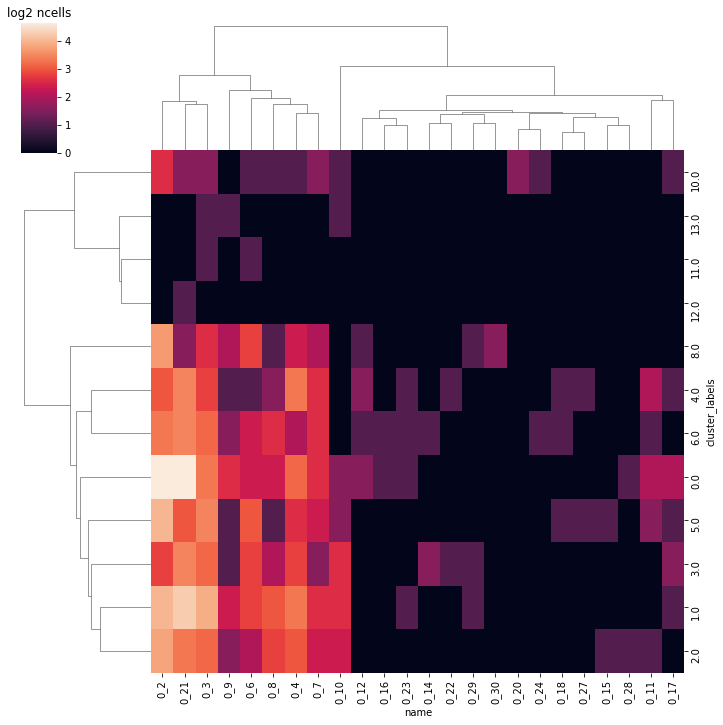

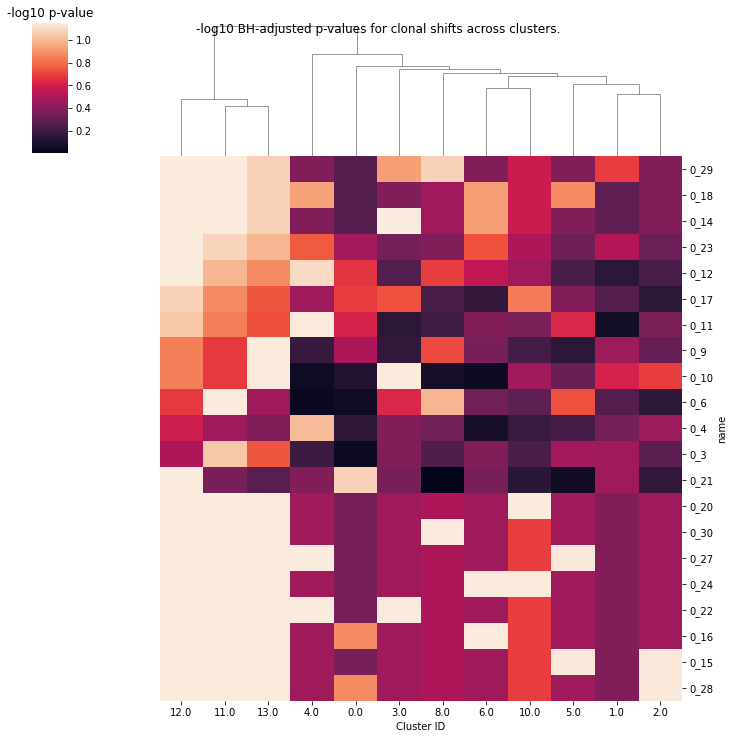

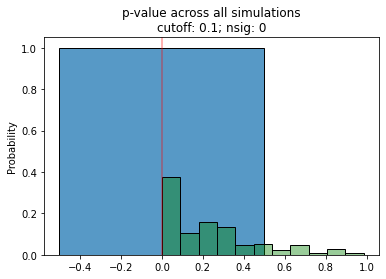

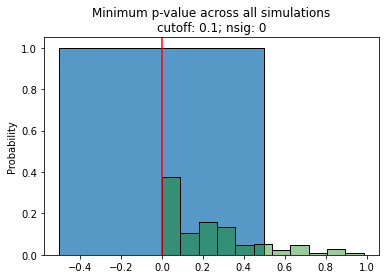

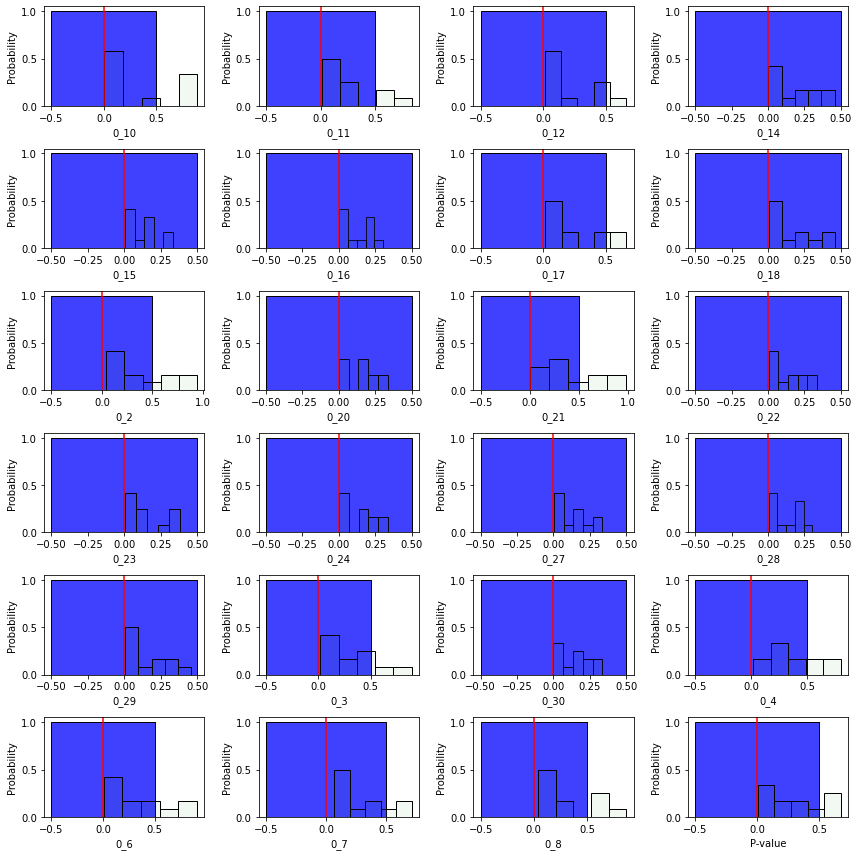

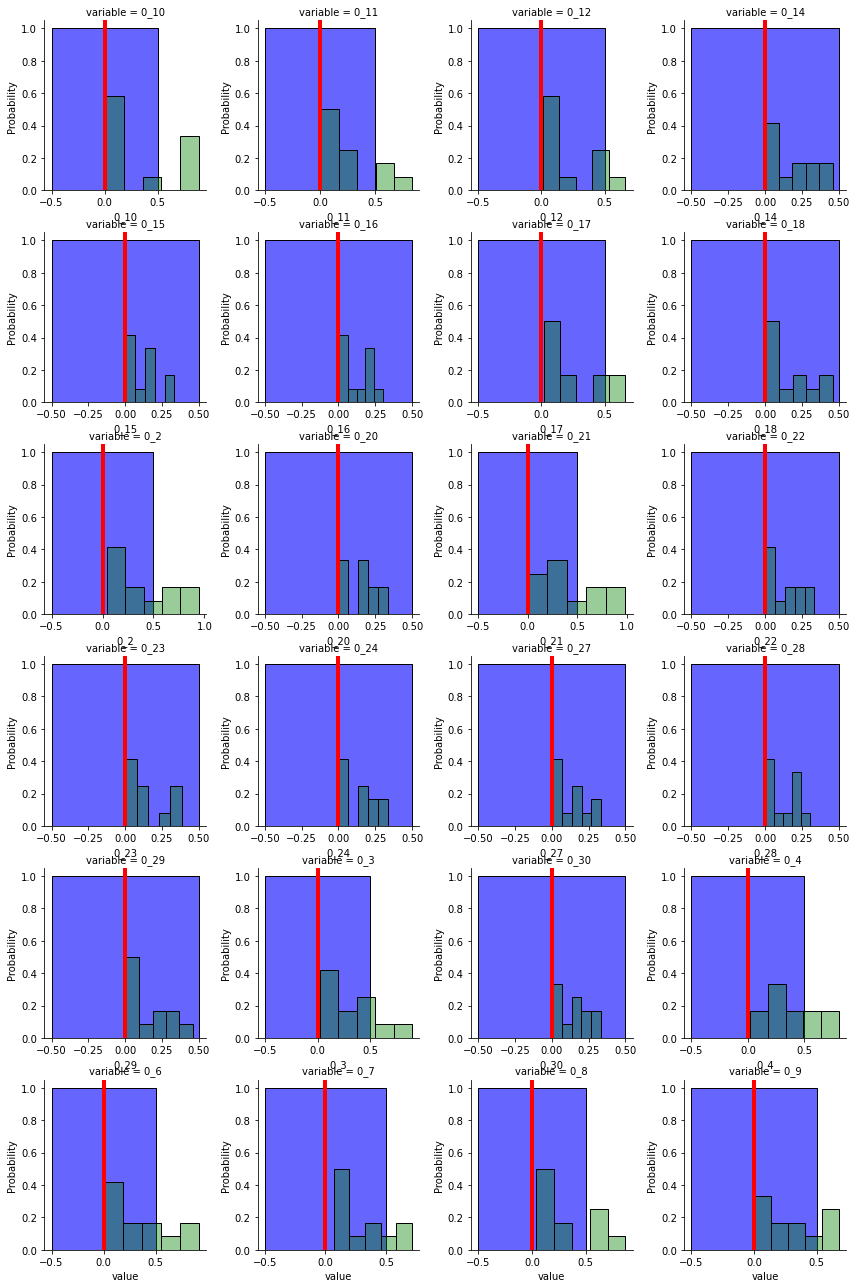

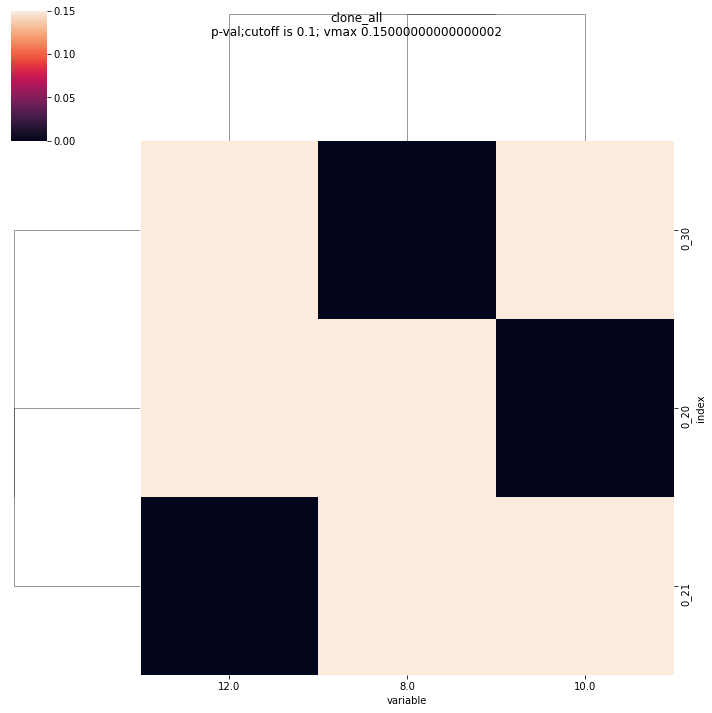

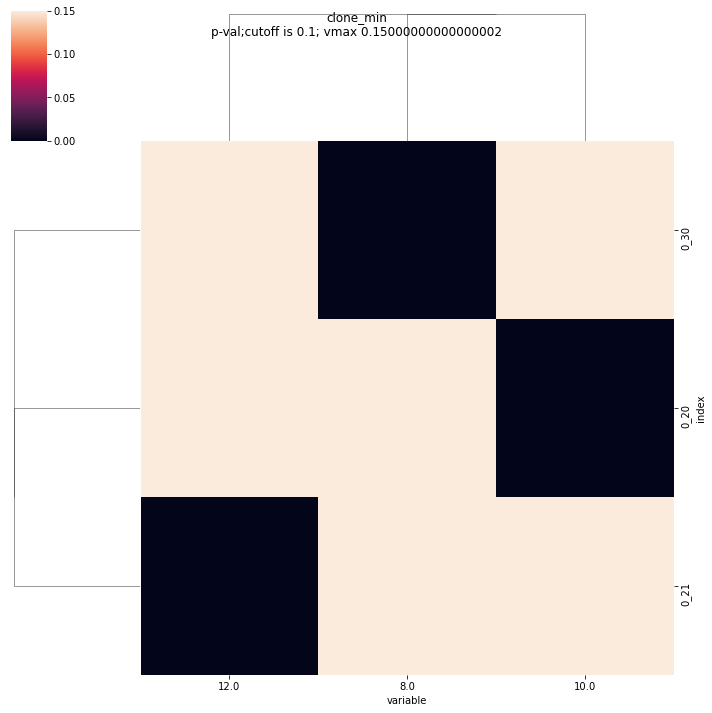

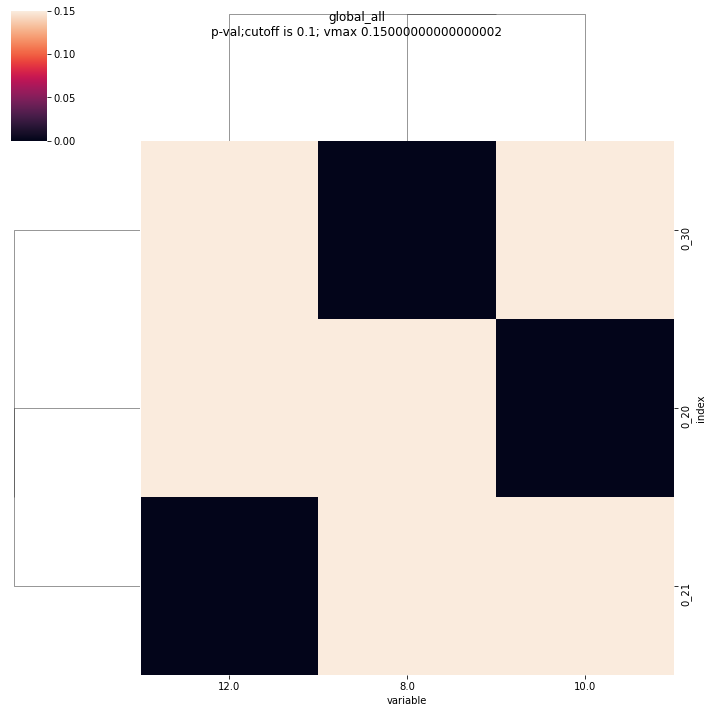

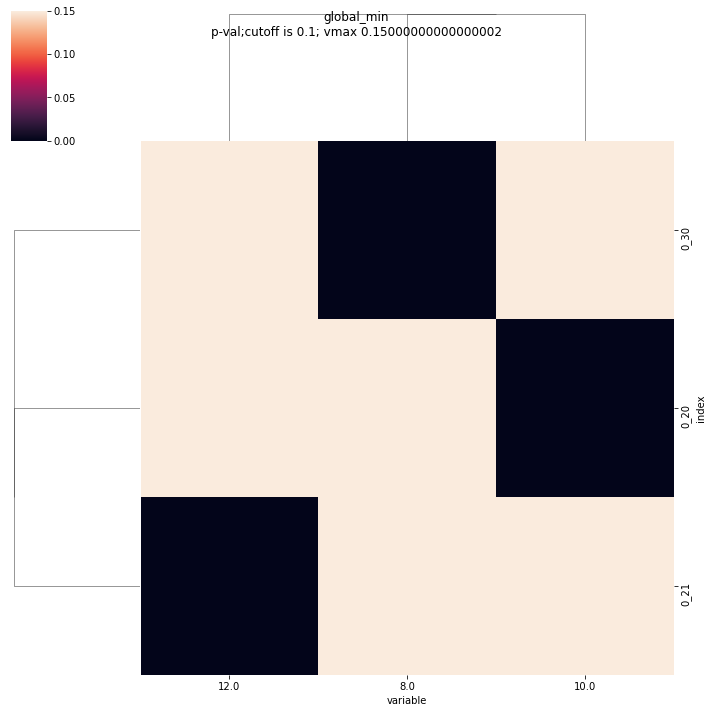

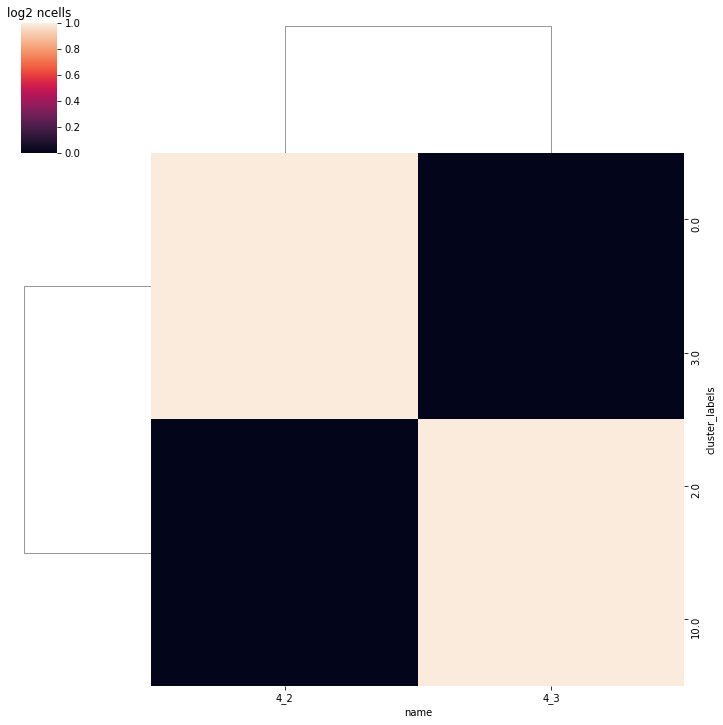

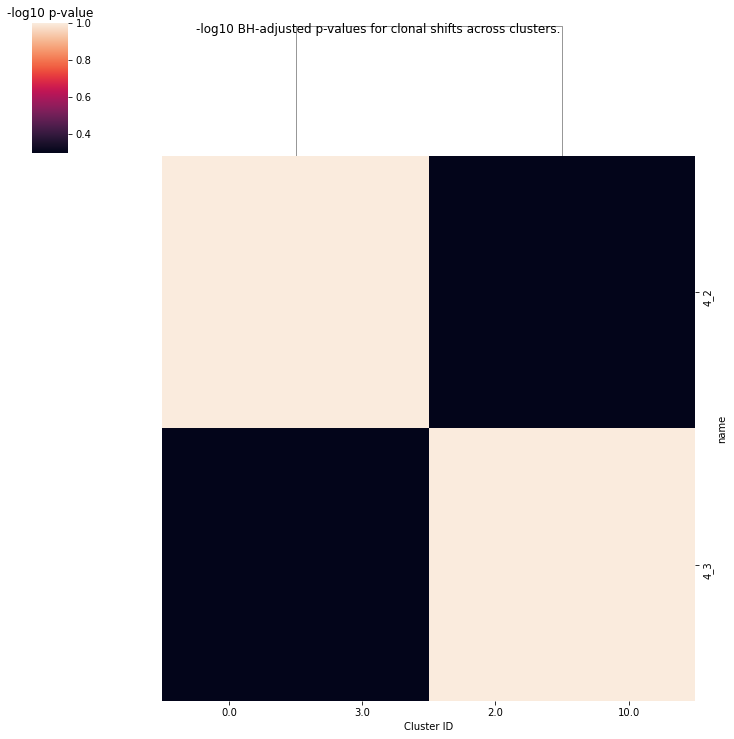

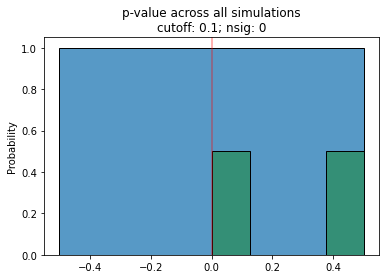

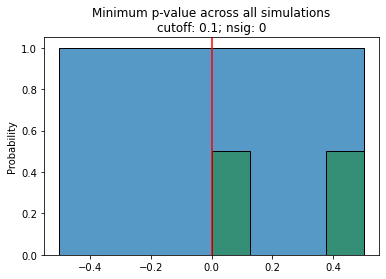

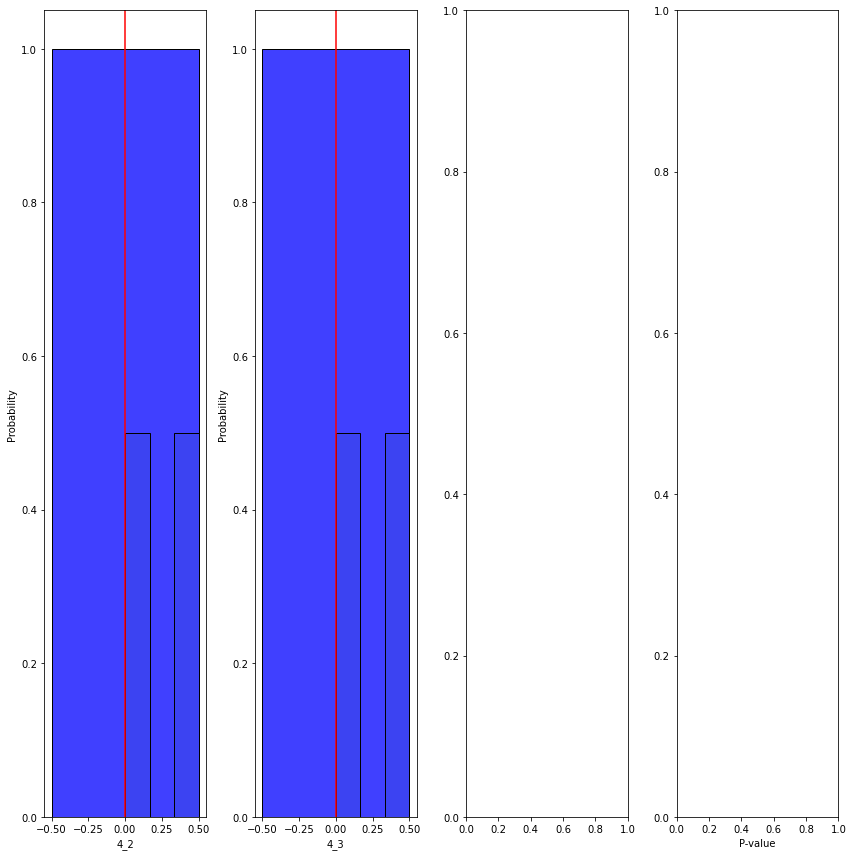

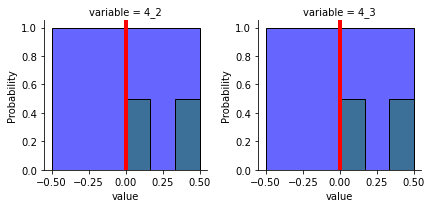

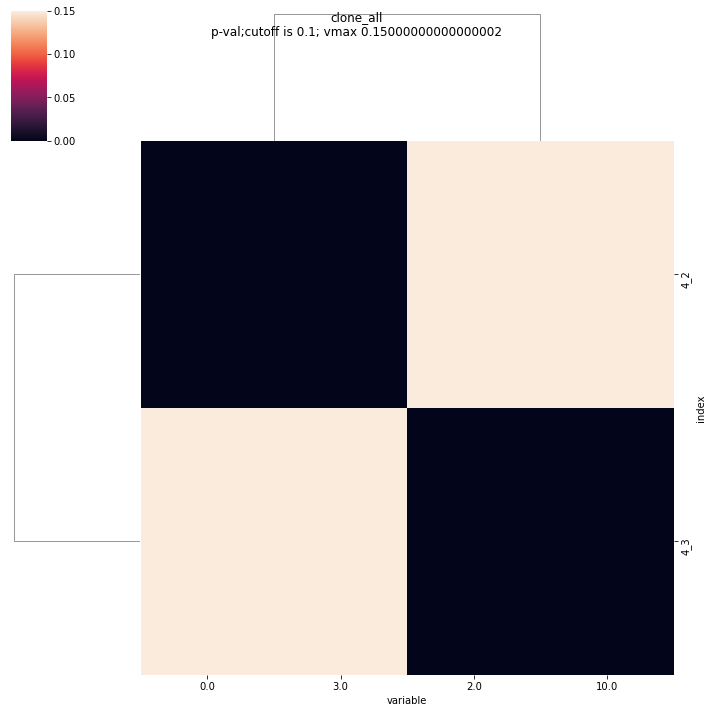

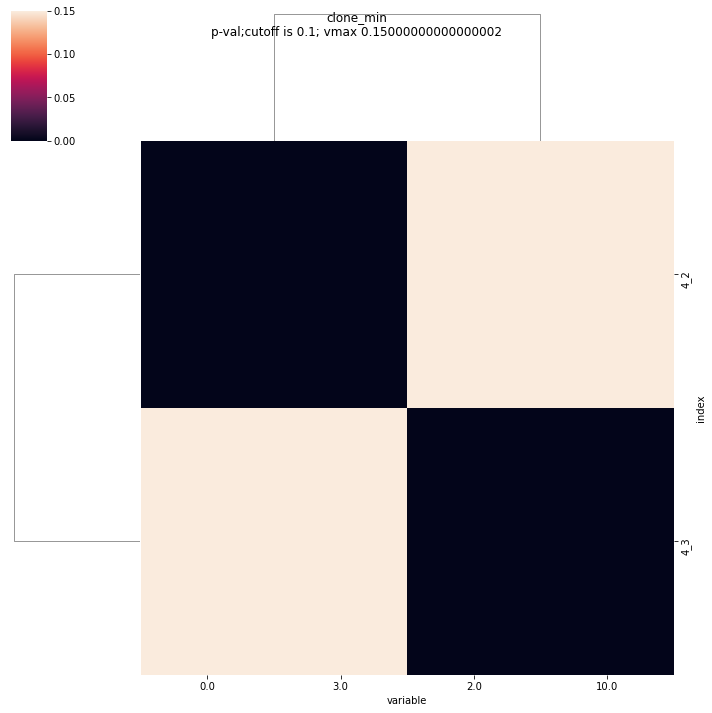

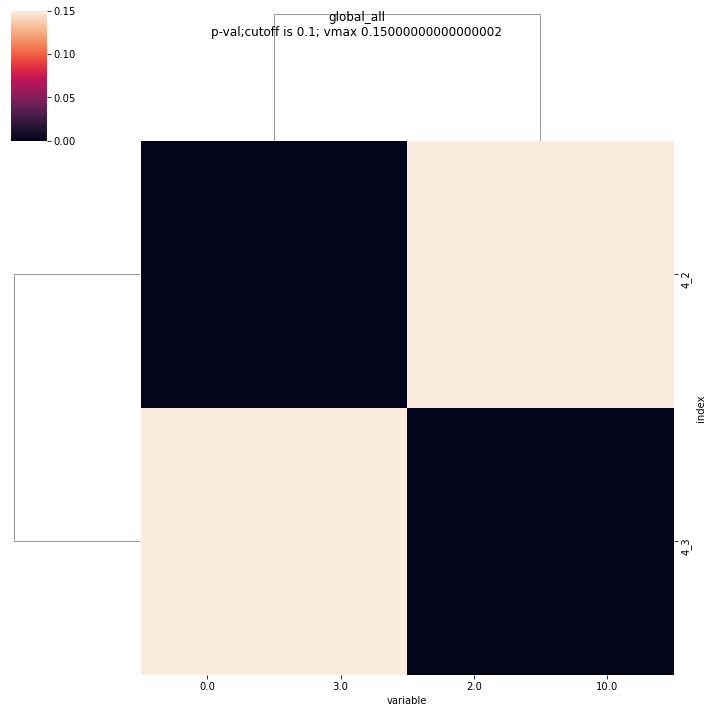

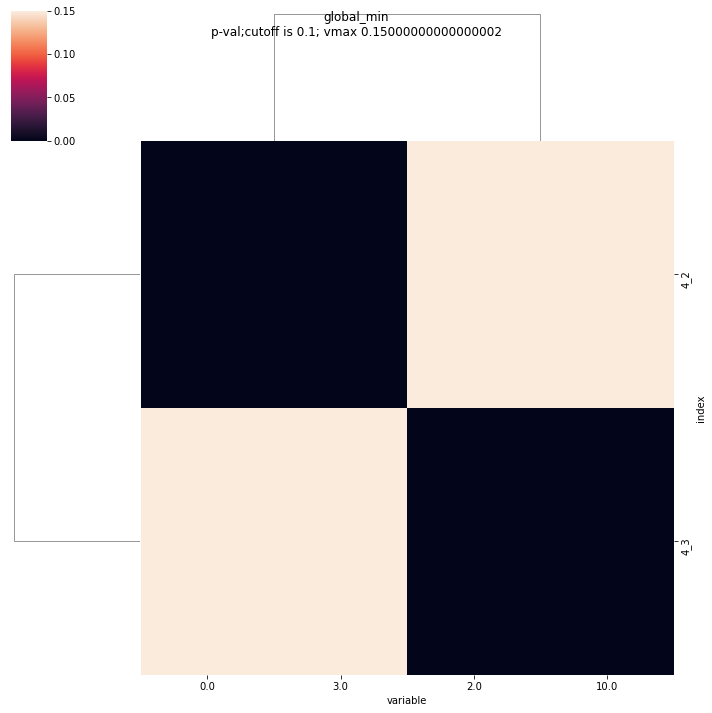

In [9]:
val = cells_meta[cells_meta["donor"].astype(str) == str(d)]


# for d, val in cells_meta.groupby("donor"):
#     print('donor', d)

curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
if len(curr_groups["cluster_labels"].unique()) == 1:
    print('only 1 cluster. not running')
    continue
curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
curr_name_cond_size = val.groupby([clone_col]).size()
curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
curr_clones_filt = curr_name_cond_size.index 
curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)

curr_clones = np.unique(curr_groups[clone_col])
curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
print(curr_clones)
curr_atac_cl = np.unique(curr_groups[atac_col])
print(curr_atac_cl)

curr_don_out = donor_out[int(d)]
if len(curr_groups) == 0:
    continue
# Run init hypergeo and the counts data
cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
               clone_col, curr_don_out)

out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                  curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

    


In [ ]:
## B) Run using all donors as background

# sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
# name_cond_size = cells_meta.groupby([clone_col]).size()
# name_cond_size = name_cond_size[name_cond_size>min_clone_size]
# clones_filt = name_cond_size.index 

# sizes = sizes.loc[clones_filt].sort_values(ascending=False)
# clones_filt

# groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
# groups

# clones = clones_filt.values #np.unique(groups["name"])
# clone_map = {x:ind for ind,x in enumerate(clones)}

# atac_cl = np.unique(groups[atac_col])
# atac_cl


# # Run init hypergeo
# cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
#                clone_col, all_dir)
# ## Run shuffle
# print("Running hypergeo shuffle and saving sig results")
# out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
#                                                   atac_cl, n_shuffle=n_shuffle, figs_close=False, 
#                                                               to_p_correct=False, n_cpus=n_cpus)